In [181]:
import pandas
import json
import datetime
import requests
import scipy
import folium
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import ttest_rel

In [182]:
import os
os.chdir('C:\Master Sapienza\Algorithmic Methods in Data Mining\homework\hw2')

# Core Research Q1

In [183]:
data = pandas.read_csv('yellow_tripdata_2018-04.csv') 

In [184]:
pandas.set_option('display.max_columns', None)
data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2018-04-01 00:22:20,2018-04-01 00:22:26,1,0.0,1,N,145,145,2,2.5,0.5,0.5,0.00,0.0,0.3,3.80
1,1,2018-04-01 00:47:37,2018-04-01 01:08:42,1,6.7,1,N,152,90,2,22.5,0.5,0.5,0.00,0.0,0.3,23.80
2,1,2018-04-01 00:02:13,2018-04-01 00:17:52,2,4.1,1,N,239,158,1,15.5,0.5,0.5,3.35,0.0,0.3,20.15
3,1,2018-04-01 00:46:49,2018-04-01 00:52:05,1,0.7,1,N,90,249,1,5.5,0.5,0.5,1.35,0.0,0.3,8.15
4,1,2018-04-01 00:19:04,2018-04-01 00:19:09,1,0.0,1,N,145,145,2,2.5,0.5,0.5,0.00,0.0,0.3,3.80


In [185]:
data['tpep_pickup_datetime'] = pandas.to_datetime(data['tpep_pickup_datetime'], format="%Y/%m/%d %H:%M:%S")
data['tpep_dropoff_datetime'] = pandas.to_datetime(data['tpep_dropoff_datetime'], format="%Y/%m/%d %H:%M:%S")

DATA CLEANING

Criteria:

_ Eliminate all trips with distance less than 0.2 miles and total amount less than 2.5.

_ Eliminate all trips with fare_amount less than 2.5

_ Eliminate all trips which are wrongly recorded in months and years.

In [186]:
trip = data.loc[(data.trip_distance > 0.2) & (data.total_amount > 2.5) &
                (data.fare_amount > 2.5) &
                (data['tpep_pickup_datetime'].dt.year == 2018) & (data['tpep_dropoff_datetime'].dt.year == 2018) &
                (data['tpep_pickup_datetime'].dt.month == 4) & (data['tpep_dropoff_datetime'].dt.month <= 5) ][['tpep_pickup_datetime','tpep_dropoff_datetime','PULocationID','DOLocationID','trip_distance', 'fare_amount']]
pickup_time = pandas.to_datetime(trip['tpep_pickup_datetime'], format = "%Y/%m/%d %H:%M:%S")
dropoff_time = pandas.to_datetime(trip['tpep_dropoff_datetime'], format = "%Y/%m/%d %H:%M:%S")
delta = (dropoff_time - pickup_time).astype('timedelta64[m]')
trip['trip_duration(mins)'] = delta

Get rid of all the trips that are unusually longer than 300 minutes and less than 1 minute

In [187]:
del data
trip = trip.loc[(trip['trip_duration(mins)'] <= 300) & (trip['trip_duration(mins)'] >= 1)]
trip.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,PULocationID,DOLocationID,trip_distance,fare_amount,trip_duration(mins)
1,2018-04-01 00:47:37,2018-04-01 01:08:42,152,90,6.7,22.5,21.0
2,2018-04-01 00:02:13,2018-04-01 00:17:52,239,158,4.1,15.5,15.0
3,2018-04-01 00:46:49,2018-04-01 00:52:05,90,249,0.7,5.5,5.0
5,2018-04-01 00:01:40,2018-04-01 00:14:21,226,83,2.5,11.5,12.0
6,2018-04-01 00:57:02,2018-04-01 01:04:57,95,135,1.8,8.5,7.0


Compute the mean and std of average fare

mean of average fare per mile 3.9754457164216848
std of average fare per mile 1.214949314645236


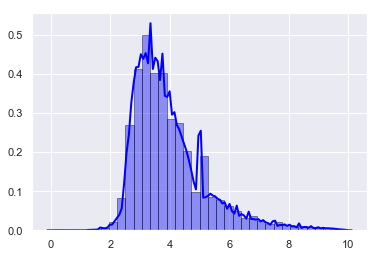

In [188]:
average_fare = (trip['fare_amount']-2.5)/trip['trip_distance']
ave = []
for i in (average_fare):
    if i > 0 and i < 10:
        ave.append(i)
print("mean of average fare per mile",np.mean(ave))
print("std of average fare per mile",np.std(ave))
sns.set(color_codes=True)
sns.distplot(ave, hist=True, kde=True, 
             bins=int(180/5), color = 'blue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})

The distribution is a unimodal model and slightly skewed left with the peak at around 3. However it has another smaller 'peak' at 5. 

Compute the means and stds for all other boroughs

In [189]:
boro = pandas.read_csv('taxi_zone_lookup.csv')
boro = boro[['LocationID', 'Borough']].set_index('LocationID')
boro.columns = ['PUBorough']
trip = trip.join(boro, on = 'PULocationID', how = 'left')
boro.columns = ['DOBorough']
trip = trip.join(boro, on = 'DOLocationID', how = 'left')
trip = trip.loc[:,['trip_distance','fare_amount','trip_duration(mins)','PUBorough','DOBorough']]
trip.head()

,trip_distance,fare_amount,trip_duration(mins),PUBorough,DOBorough
1,6.7,22.5,21.0,Manhattan,Manhattan
2,4.1,15.5,15.0,Manhattan,Manhattan
3,0.7,5.5,5.0,Manhattan,Manhattan
5,2.5,11.5,12.0,Queens,Queens
6,1.8,8.5,7.0,Queens,Queens


In [190]:
Q = trip.loc[trip["PUBorough"] == 'Queens' ][['trip_distance', 'fare_amount']]
Qaverage_fare = (Q['fare_amount']-2.5)/Q['trip_distance'] #not taking into account 2.5$ initial subcharge
print(np.mean(Qaverage_fare))
print(np.std(Qaverage_fare))

3.088054368509667
2.9289967934722627


In [191]:
M = trip.loc[trip["PUBorough"] == 'Manhattan' ][['trip_distance', 'fare_amount']]
Maverage_fare = (M['fare_amount']-2.5)/M['trip_distance'] #not taking into account 2.5$ initial subcharge
print(np.mean(Maverage_fare))
print(np.std(Maverage_fare))

4.131371743098349
2.1016955277226375


In [192]:
Bx = trip.loc[trip["PUBorough"] == 'Bronx' ][['trip_distance', 'fare_amount']]
Bxaverage_fare = (Bx['fare_amount']-2.5)/Bx['trip_distance'] #not taking into account 2.5$ initial subcharge
print(np.mean(Bxaverage_fare))
print(np.std(Bxaverage_fare))

3.643911151841427
6.2214656424477885


In [193]:
Br = trip.loc[trip["PUBorough"] == 'Brooklyn' ][['trip_distance', 'fare_amount']]
Braverage_fare = (Br['fare_amount']-2.5)/Br['trip_distance'] #not taking into account 2.5$ initial subcharge
print(np.mean(Braverage_fare))
print(np.std(Braverage_fare))

3.5790496842169324
2.74786795579384


In [194]:
S = trip.loc[trip["PUBorough"] == 'Staten Island' ][['trip_distance', 'fare_amount']]
Saverage_fare = (S['fare_amount']-2.5)/S['trip_distance'] #not taking into account 2.5$ initial subcharge
print(np.mean(Saverage_fare))
print(np.std(Saverage_fare))

3.1679457056375515
1.7590250735956372


In [195]:
E = trip.loc[trip["PUBorough"] == 'EWR' ][['trip_distance', 'fare_amount']]
Eaverage_fare = (E['fare_amount']-20)/E['trip_distance'] #not taking into account 20$ initial subcharge
print(np.mean(Eaverage_fare))
print(np.std(Eaverage_fare))

20.36925815387621
41.279755550046616


# STATISTIC TESTS

In [196]:
# Null hypothesis: The average price per kilometer in each borough is the same 
# H1: The average price per kilometer in each borough is significantly different 
# Paired Student’s t-Test
List1 = [Qaverage_fare]
List2 = [Maverage_fare]
List3 = [Bxaverage_fare]
List4 = [Braverage_fare]
List5 = [Saverage_fare]
List6 = [Eaverage_fare]
xd = {'Queens': List1, 'Manhattan': List2, 'Bronx': List3, 'Brooklyn': List4, 'StatenIsland': List5, 'EWR': List6}

for k, v in xd.items():
    for k1, v1 in xd.items():
        if k == k1:
            break
        else:
            print('Comparing average fare of %s and %s' % (k, k1))
            if len(v[0]) >= len(v1[0]):
                # compare samples
                stat, p = ttest_rel(v[0][:len(v1[0])], v1[0])
                print('Statistics=%.3f, p=%.3f' % (stat, p))
                # interpret
                alpha = 0.05
                if p > alpha:
                    print('Same distributions (accept H0)')
                else:
                    print('Different distributions (reject H0)')
            else:
                # compare samples
                stat, p = ttest_rel(v[0], v1[0][:len(v[0])])
                print('Statistics=%.3f, p=%.3f' % (stat, p))
                # interpret
                alpha = 0.05
                if p > alpha:
                    print('Same distributions (accept H0)')
                else:
                    print('Different distributions (reject H0)')

Comparing average fare of Manhattan and Queens
Statistics=162.802, p=0.000
Different distributions (reject H0)
Comparing average fare of Bronx and Queens
Statistics=10.031, p=0.000
Different distributions (reject H0)
Comparing average fare of Bronx and Manhattan
Statistics=2.382, p=0.017
Different distributions (reject H0)
Comparing average fare of Brooklyn and Queens
Statistics=53.061, p=0.000
Different distributions (reject H0)
Comparing average fare of Brooklyn and Manhattan
Statistics=18.490, p=0.000
Different distributions (reject H0)
Comparing average fare of Brooklyn and Bronx
Statistics=-2.980, p=0.003
Different distributions (reject H0)
Comparing average fare of StatenIsland and Queens
Statistics=1.201, p=0.234
Same distributions (accept H0)
Comparing average fare of StatenIsland and Manhattan
Statistics=-1.376, p=0.173
Same distributions (accept H0)
Comparing average fare of StatenIsland and Bronx
Statistics=0.242, p=0.810
Same distributions (accept H0)
Comparing average fare

Based on the test results above, we can see that the average fare price in Newark Liberty International Airport is significantly different from other boroughs(we are considering the initial pick-up location in this case).

Compute the weighted mean and std of average fare

mean of 27.40573455736711
std of 22.35200646931189


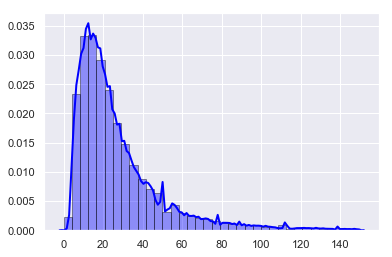

In [197]:
Pprime = average_fare * (trip['trip_duration(mins)']/trip['trip_distance'])
Pave = []
for i in (Pprime):
    if i > 0 and i < 150:
        Pave.append(i)
print("mean of",np.mean(Pave))
print("std of",np.std(Pave))
sns.set(color_codes=True)
sns.distplot(Pave, hist=True, kde=True, 
             bins=int(180/5), color = 'blue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})

The distribution model is unimodal and heavily skewed to the left. The peak is at 15-18.

In [198]:
Qw = trip.loc[trip["PUBorough"] == 'Queens' ][['trip_distance', 'fare_amount','trip_duration(mins)']]
Qwaverage_fare = (Qw['fare_amount']-2.5)/Qw['trip_distance'] * (Qw['trip_duration(mins)']/Qw['trip_distance'])
print(np.mean(Qwaverage_fare))
print(np.std(Qwaverage_fare))

11.242825765109702
179.01135525659075


In [199]:
Mw = trip.loc[trip["PUBorough"] == 'Manhattan' ][['trip_distance', 'fare_amount','trip_duration(mins)']]
Mwaverage_fare = (Mw['fare_amount']-2.5)/Mw['trip_distance'] * (Mw['trip_duration(mins)']/Mw['trip_distance'])
print(np.mean(Mwaverage_fare))
print(np.std(Mwaverage_fare))

31.809413001745057
97.0103278591952


In [200]:
Bxw = trip.loc[trip["PUBorough"] == 'Bronx' ][['trip_distance', 'fare_amount','trip_duration(mins)']]
Bxwaverage_fare = (Bxw['fare_amount']-2.5)/Bxw['trip_distance'] * (Bxw['trip_duration(mins)']/Bxw['trip_distance'])
print(np.mean(Bxwaverage_fare))
print(np.std(Bxwaverage_fare))

27.834922096434813
757.9737937713134


In [201]:
Brw = trip.loc[trip["PUBorough"] == 'Brooklyn' ][['trip_distance', 'fare_amount','trip_duration(mins)']]
Brwaverage_fare = (Brw['fare_amount']-2.5)/Brw['trip_distance'] * (Brw['trip_duration(mins)']/Brw['trip_distance'])
print(np.mean(Brwaverage_fare))
print(np.std(Brwaverage_fare))

19.608618032199335
43.782829609858524


In [202]:
Sw = trip.loc[trip["PUBorough"] == 'Staten Island' ][['trip_distance', 'fare_amount','trip_duration(mins)']]
Swaverage_fare = (Sw['fare_amount']-2.5)/Sw['trip_distance'] * (Sw['trip_duration(mins)']/Sw['trip_distance'])
print(np.mean(Swaverage_fare))
print(np.std(Swaverage_fare))

8.630331005277888
5.88736949365818


In [203]:
Ew = trip.loc[trip["PUBorough"] == 'EWR' ][['trip_distance', 'fare_amount','trip_duration(mins)']]
Ewaverage_fare = (Ew['fare_amount']-20)/Ew['trip_distance'] * (Ew['trip_duration(mins)']/Ew['trip_distance'])
print(np.mean(Ewaverage_fare))
print(np.std(Ewaverage_fare))

39.24052979006258
94.94939137539826


# STATISTIC TESTS

In [204]:
# Null hypothesis: The weighted average price per kilometer in each borough is the same with the weighted average price in New York
# H1: The weighted average price per kilometer in each borough is significantly different from the weighted average price in New York
# Paired Student’s t-Test

List1 = [Qwaverage_fare]
List2 = [Mwaverage_fare]
List3 = [Bxwaverage_fare]
List4 = [Brwaverage_fare]
List5 = [Swaverage_fare]
List6 = [Ewaverage_fare]

xd1 = {'Queens': List1, 'Manhattan': List2, 'Bronx': List3, 'Brooklyn': List4, 'StatenIsland': List5, 'EWR': List6}

for k, v in xd1.items():
    for k1, v1 in xd1.items():
        if k == k1:
            break
        else:
            print('Comparing weighted average fare of %s and %s' % (k, k1))
            if len(v[0]) >= len(v1[0]):
                # compare samples
                stat, p = ttest_rel(v[0][:len(v1[0])], v1[0])
                print('Statistics=%.3f, p=%.3f' % (stat, p))
                # interpret
                alpha = 0.05
                if p > alpha:
                    print('Same distributions (accept H0)')
                else:
                    print('Different distributions (reject H0)')
            else:
                # compare samples
                stat, p = ttest_rel(v[0], v1[0][:len(v[0])])
                print('Statistics=%.3f, p=%.3f' % (stat, p))
                # interpret
                alpha = 0.05
                if p > alpha:
                    print('Same distributions (accept H0)')
                else:
                    print('Different distributions (reject H0)')

Comparing weighted average fare of Manhattan and Queens
Statistics=61.693, p=0.000
Different distributions (reject H0)
Comparing weighted average fare of Bronx and Queens
Statistics=2.462, p=0.014
Different distributions (reject H0)
Comparing weighted average fare of Bronx and Manhattan
Statistics=1.179, p=0.238
Same distributions (accept H0)
Comparing weighted average fare of Brooklyn and Queens
Statistics=61.244, p=0.000
Different distributions (reject H0)
Comparing weighted average fare of Brooklyn and Manhattan
Statistics=14.687, p=0.000
Different distributions (reject H0)
Comparing weighted average fare of Brooklyn and Bronx
Statistics=-1.279, p=0.201
Same distributions (accept H0)
Comparing weighted average fare of StatenIsland and Queens
Statistics=-0.376, p=0.708
Same distributions (accept H0)
Comparing weighted average fare of StatenIsland and Manhattan
Statistics=-5.750, p=0.000
Different distributions (reject H0)
Comparing weighted average fare of StatenIsland and Bronx
Stat

Based on the test results, we can see that the weight average price per mile is divided into 2 groups. The group with higher weighted average price includes Manhattan, Bronx and Newark Liberty International Airport. The other includes Queens, Brooklyn and Staten Island. These two groups have a significant difference in weighted average price indicating that the former group is the one of busy boroughs with longer waiting time.

# Core Research Q2

Counting the number of trips starting in each borough

In [205]:
PUQ = trip[trip.PUBorough == 'Queens']
PUMan = trip[trip.PUBorough == 'Manhattan']
PUBx = trip[trip.PUBorough == 'Bronx']
PUBr = trip[trip.PUBorough == 'Brooklyn']
PUSt = trip[trip.PUBorough == 'Staten Island']
PUE = trip[trip.PUBorough == 'EWR']

In [206]:
List1 = ['Queens','Manhattan','Bronx','Brooklyn','Staten Island','EWR']
List2 = [len(PUQ),len(PUMan),len(PUBx),len(PUBr),len(PUSt),len(PUE)]
count = {'District': List1, 'Number': List2}
df = pandas.DataFrame(data=count)
df.to_json('df.json')
df = df.reset_index()
df.columns = ['List','District', 'Number']
df

,List,District,Number
0,0,Queens,575034
1,1,Manhattan,8314071
2,2,Bronx,9551
3,3,Brooklyn,115354
4,4,Staten Island,70
5,5,EWR,42


Choropleph the map and save the output into html file

In [207]:
url = 'https://raw.githubusercontent.com/CriMenghini/ADM-2018/master/Homework_2/taxi_zones.json'
response = requests.get(url)
nyc = folium.Map(location=[40.7,-74.0], zoom_start=11)
nyc.choropleth(response.text,fill_opacity=0.5, line_opacity=0.5,
               fill_color='YlOrRd',
               threshold_scale = [2,20,200,20000,200000,2000000],
               data = df,
               key_on='feature.properties.borough',
               columns=['District', 'Number']
              )

nyc.save(outfile='nyc.html')

Counting the number of trips starting and ending in the same borough

In [208]:
SameLocation = trip[trip.PUBorough == trip.DOBorough]
Same_Queens = SameLocation[SameLocation.PUBorough == 'Queens']
Same_Manhattan = SameLocation[SameLocation.PUBorough == 'Manhattan']
Same_Bronx = SameLocation[SameLocation.PUBorough == 'Bronx']
Same_Brooklyn = SameLocation[SameLocation.PUBorough == 'Brooklyn']
Same_StatenIsland = SameLocation[SameLocation.PUBorough == 'Staten Island']
Same_EWR = SameLocation[SameLocation.PUBorough == 'EWR']

In [209]:
List3 = [len(Same_Queens),len(Same_Manhattan),len(Same_Bronx),len(Same_Brooklyn),len(Same_StatenIsland),len(Same_EWR)]
count1 = {'District': List1, 'Number': List3}
df1 = pandas.DataFrame(data=count1)
df1.to_json('df1.json')
df1 = df1.reset_index()
df1.columns = ['List','District', 'Number']
df1

,List,District,Number
0,0,Queens,128286
1,1,Manhattan,7718930
2,2,Bronx,4892
3,3,Brooklyn,73405
4,4,Staten Island,25
5,5,EWR,15


Choropleph the map and save the output into html file

In [210]:
nyc_samelocation = folium.Map(location=[40.7,-74.0], zoom_start=11)
nyc_samelocation.choropleth(response.text,fill_opacity=0.5, line_opacity=0.5,
               fill_color='YlOrRd',
               threshold_scale = [2,20,200,20000,200000,2000000],
               data = df1,
               key_on='feature.properties.borough',
               columns=['District', 'Number']
              )

nyc_samelocation.save(outfile='nyc_samelocation.html')

Based on the visualization, we observe that the majority of trips started in Manhattan and ended in the same borough.

The most conspicuous difference in the maps is the case of Queens borough, as the number of trips starting and ending in Queens noticeably differs from the number of trips in Queens when we only take into account starting borough